This project helps to get insight about the various offers displayed on Flipkart bigbillion days.
Following are the questions answered by this project.


Questions



1. * a) Top 10 products with price trending downwards by category.
   * b) Top 10 products with price trending upwards by category. 

2. Which categories have the highest discount 

3. * a) Does Rating affect the discount percentage for products within a category? 
   * b) Does Rating affect the discount percentage for each category within the dataset? 

4. * a)Mobile companies with maximum discount. 
   * b) Mobile companies with minimum discount 

5. Trends for discounts on mobile, laptop & tablets for the same company 

6. What is the confidence score of each company's monitor price with corresponding TV price. 

7. Top 2 companies with max discount percentage for HDD and SSD 1000 reviews and >4 rating having similar specifications  

8. Which companies have mobile phones with consecutive increase in discount rates with less than a certain rating X . 

9. Fluctuation of each company's aggregate discount rate over all the products during the sale. Consider companies with more than N products. 

10. Trends for prices between laptops and accessories (peripherals) over the time period. 

11. Analysis of companies changing their discount rates over the time period based on competitors' rates for products with the same hardware and software specifications for Mobiles and Laptops. 

12. Changes in discount rates based on increase in number of reviews/rating for each product over the given time period for various product and companies. 

13. Volatility of discount rates for stable products Vs. newly introduced products. Will use number of ratings/reviews as an indicator for new & old products. 

14. Variations in discount rate of different models of the same product for a company over the given time period. 



- This project will use pyspark to load the stat and analyse the data.

# Core Data Loading & Common codes

In [1]:
#######################################
###!@0 START INIT ENVIRONMENT

from datetime import *
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!tar xf /content/drive/Shareddrives/DA231-2022-public/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf /content/drive/MyDrive/Shareddrives/DA231-2022-public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

# Install vader lexicon for sentiment analysis in Q5
!python -m nltk.downloader vader_lexicon
 
###!@0 END INIT ENVIRONMENT

Mounted at /content/drive
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
#######################################
###!@1 START OF PYSPARK INIT
import pandas as pd
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
from pyspark.sql.functions import lit
import datetime
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

In [3]:
#######################################
###!@2 START OF DEFINING INPUT FILES
#tfile = "/content/drive/MyDrive/Data Engineering Project/sub set"
#tfile = "/content/drive/MyDrive/Data Engineering Project/Dataset/Data"
#tfile = "/content/drive/MyDrive/Data Engineering Project/test"
tfile = "/content/drive/MyDrive/Data Engineering Project/Dataset/Consolidated_Data/Data_noimages_both"
tfile = "/content/drive/MyDrive/Data Engineering Project/Data/Data"
###!@2 END OF DEFINING INPUT FILES

from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf
import sys
import json

list_cat = os.listdir(tfile)
dir_list = []
res=[]

columns = ['u_id','name','offer_price','original_price','off_now','total_ratings','total_reviews','rating','description','item_link','created_at','Category','SCategory']
vals = [('DWV2EO5S','realme 9i (Prism Black, 128 GB)',11099,16999,'34% off',84095,4630,4.5,'desc. asd','url test',datetime.datetime.now(),'testing','test')]

df = spark.createDataFrame(vals, columns)
df_old = spark.createDataFrame(vals, columns)



def load (dir,cat,sub_cat):
  columns = ['u_id','name','offer_price','original_price','off_now','total_ratings','total_reviews','rating','description','item_link','created_at','Category','SCategory']
  vals = [('DWV2EO5S','realme 9i (Prism Black, 128 GB)',11099,16999,'34% off',84095,4630,4.5,'desc. asd','url test',datetime.datetime.now(),'testing','test')]

  df_old_lo = spark.createDataFrame(vals, columns)
  list_file = os.listdir(dir)
  for i in range(len(list_file)):
      if '.csv' in list_file[i]:
        df_lo = spark.read.option("header",True) \
        .csv(dir+'/'+list_file[i])
        columns = df_lo.columns
        h=0
        d=0
        j=0
        ra = 0
        for head in columns:
          if head == 'u_id':
            h=1
          if head == 'description':
            d=1
          if head == 'item_link':
            j=1
          if head == 'rating_breakup':
            ra=1
        if h==0:
          df_lo = df_lo.withColumn("u_id", lit('N/A'))
        if d==0:
          df_lo = df_lo.withColumn("description", lit('N/A'))
        if j==0:
          df_lo = df_lo.withColumn("item_link", lit('N/A'))
        if ra==1:
          df_lo = df_lo.drop("rating_breakup")
        df_lo1 = df_lo.withColumn("Category", lit(cat))
        df1 = df_lo1.withColumn("SCategory", lit(sub_cat))

        if i ==0:
          df=df1
          df_old_lo = df
        else:
          #print(list_file[i])
          #print(cat+'/')
          #print(sub_cat)
          df = df_old_lo.unionByName(df1)
          df_old_lo = df
        i= i+1
  return (df)


for cat in list_cat:
  print(cat)
  list_sub_cat = os.listdir(tfile+'/'+cat)
  for sub_cat in list_sub_cat:
    print(sub_cat)
    if '.csv' in sub_cat:
      dir = (tfile+'/'+cat+'/')
      df1=load(dir,cat,None)
      df = df_old.unionByName(df1)
      df_old = df
      break
    elif sub_cat != 'Images':
      dir=(tfile+'/'+cat+'/'+sub_cat)
      df1=load(dir,cat,sub_cat)
      df = df_old.unionByName(df1)
      df_old = df

Big_b_start = date(2022, 9, 23)
Big_b_end = date(2022,9, 30)

df = df.filter(df.Category!='testing')
df = df.withColumn("offer_price",df["offer_price"].cast('float'))
df = df.withColumn("created_at",df["created_at"].cast('date'))
df = df.withColumn("rating",df["rating"].cast('float'))
df = df.withColumn("total_ratings",df["total_ratings"].cast('float'))
df = df.withColumn("original_price",df["original_price"].cast('float'))
df = df.withColumn("total_reviews",df["total_reviews"].cast('float'))
df = df.withColumn("Big_Billion", F.when((F.col("created_at")<Big_b_start) | (F.col("created_at")>Big_b_end),'Not').otherwise('Big'))
spark.catalog.dropGlobalTempView("master")
print(df.count())
_tmapRDD = df.cache()


###!@3 END OF LOADING DATA

other_electronics
washingmachine
smartwatch
fridge
ac
waterpurifier
peripherals
pen_drives
monitor
power_bank
wired_headset
earbuds
ssd
memory_cards
hdd
tvs
23_09_2022.csv
tablet
16_10_2022.csv
laptops
30_09_2022.csv
mobiles
24_09_2022.csv
177031


In [4]:
cat = _tmapRDD.filter(_tmapRDD.Big_Billion == 'Big')
df2 = cat.groupBy("Category","SCategory").count()
df2.show()

+-----------------+-------------+-----+
|         Category|    SCategory|count|
+-----------------+-------------+-----+
|      peripherals|      monitor| 2809|
|      peripherals| memory_cards| 3817|
|           tablet|         null|  525|
|          mobiles|         null| 7488|
|              tvs|         null| 7464|
|      peripherals|          hdd| 2423|
|          laptops|         null| 7703|
|      peripherals|      earbuds| 5000|
|      peripherals|   power_bank| 5000|
|      peripherals|   pen_drives| 4960|
|other_electronics|waterpurifier|  481|
|      peripherals|          ssd| 2724|
|      peripherals|wired_headset| 5011|
|other_electronics|   smartwatch| 1332|
+-----------------+-------------+-----+



In [5]:
################# All imports ####################
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql import Window
import pandas as pd
import time
import math
import statistics
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np 

In [6]:
###### All custom function definitions ######

features = {'laptop': ['GB SSD', 'RAM', 'Processor', 'Operating System'],
            'mobiles':['GB ROM', 'GB RAM', 'Processor', 'Battery']}

# Function to get first word on the input.
def first_word(words):
    return words.split()[0]

# UDF to get first word on the input.
firstword = F.udf(first_word)

# Function to calculate offer percentage
def udf_off(orginal, offer):
    if orginal == 0 or offer == 0:
      return 0;
    return 100 - ((offer / orginal) * 100)

# UDF to calculate offer percentage
off = F.udf(udf_off, FloatType())

# Function to get review calulation per row
def udf_top_review(total_rating, rating, off_list):
  consider_total_ratings_above = 3.9
  if len(off_list) < 2:
      return -1
  if rating < consider_total_ratings_above:
      return -1
  return total_rating * rating

# Function to get review calulation per row
topreview = F.udf(udf_top_review, FloatType())

# Function to extract feature value from input strings of feature + values
def extract_feature(words, feature):
    items = words.split(',')
    for item in items:
        subitem = item.split('|')
        for sitem in subitem:
          if sitem.find(feature) > -1:
              val = sitem[:sitem.find(feature)]
              val = val.replace('[', '')
              return val.replace("'", '').strip()
    return 'NA'

# UDFunction to extract feature value from input strings of feature + values
extractfeature = F.udf(extract_feature)

# Function to check the array is in increasing or decreasing order
def is_increasing(ar):
  if len(ar) < 2:
    return 'NA'
  elif ar[0] < ar[len(ar)-1]:
    return 'Increasing'
  elif ar[0] > ar[len(ar)-1]:
    return 'Decreasing'
  else:
    return 'NoChange'

# UDFunction to check the array is in increasing or decreasing order
isincreasing = F.udf(is_increasing)

# Function to product is old or new based on the review and rattings
def is_old_stable_product(rating, reviews, stars):
  if (rating is None or rating == '') or (reviews is None or reviews == '') or (stars is None or stars == ''):
    return 'No'
  if rating > 10 and reviews > 50 and stars > 2.5:
    return 'Yes'
  else:
    return 'No'

# UDFunction to product is old or new based on the review and rattings
isoldstable = F.udf(is_old_stable_product)

# Function to find the volataility of the input array
def std_dev_for_list(items):
  if (len(items) < 2):
    return 'NA'
  else:
    return statistics.stdev(items)

# UDF to find the volataility of the input array
stddev = F.udf(std_dev_for_list)

# Function to add Brandname and offer percentage
def addBrandAndOfferValue(df):
  df = df.withColumn('Brand', lit(firstword(df.name)))
  df = df.withColumn('off', off(df.original_price,
                              df.offer_price))
  return df
  
# Function to add the spec values to filter
def fetchSpecFilter(df, spec_filter):
  for item in spec_filter:
      dummyname = item + '__'
      df = df.withColumn(dummyname, lit(item))
      df = df.withColumn(item,
              lit(extractfeature(df.description, dummyname)))
      df = df.drop(dummyname)
  return df

def dropUnwantedCols(df):
    df = df.drop(*[
      'u_id',
      'offer_price',
      'original_price',
      'off_now',
      'description',
      'item_link',
      'Category',
      'SCategory',
      'Big_Billion',
      ])
    return df


# Q 11 Function definition
#  Analysis of companies changing their discount rates over the time period based on competitors' 
# rates for products with the same hardware and software specifications for Mobiles and Laptops.

def topBrandOfferComparision(category, spec_filter):
  laptops = _tmapRDD.filter(F.col('Category').like(category))

  
  laptops = addBrandAndOfferValue(laptops)

  laptops = fetchSpecFilter(laptops, spec_filter)

  laptops = dropUnwantedCols(laptops)

  laptops.sort(F.col('created_at').asc())

  laptops.count()

  w = Window.partitionBy('name').orderBy(col('created_at')).rowsBetween(-10,
          Window.currentRow)
  output = laptops.withColumn('off_list',
                              F.collect_list(F.when(F.col('off'
                              ).isNull(), 0).otherwise(F.col('off'
                              ))).over(w))
  #laptops.show(truncate = False)

  w2 = Window.partitionBy("Brand").orderBy(col("created_at").desc())
  output = output.withColumn("row",F.row_number().over(w2)) \
  .filter(col("row") == 1).drop("row") 


  #output.printSchema()

  print (spec_filter)
  for spec in spec_filter:
    output = output.filter(F.col(spec).startswith(spec_filter[spec]))

  output = output.filter(F.size(col('off_list'))>1)
  output = output.withColumn('Top_review',
                            lit(topreview(output.total_ratings,
                            output.rating, output.off_list)))

  output.orderBy(col("Top_review").desc())#.show()


  w_top_per_brand = Window.partitionBy('Brand').orderBy(F.col('Top_review'
          ).desc())


  output = output.withColumn('row',
                            F.row_number().over(w_top_per_brand)).filter(col('row'
          ) == 1).drop('row')

  output = output.drop(*[
      'total_ratings',
      'total_reviews',
      'rating',
      'created_at',
      'off',
      'GB SSD',
      'RAM',
      'Processor',
      'Operating System',
      'Top_review',
      ])
  
  output.show(truncate=False)
  return output

# Q 12 Function defn for
# Changes in discount rates based on increase in number of reviews/rating for each product over the given time period for various product and companies. 
def topBrandReviewsVsOffer(category, spec_filter):
  components = _tmapRDD.filter(F.col('Category').like(category))

  components = addBrandAndOfferValue(components)

  components = fetchSpecFilter(components, spec_filter)

  
  #components.show(truncate = False)

  components.sort(F.col('created_at').asc())

  components = dropUnwantedCols(components)

  #components.count()

  w = Window.partitionBy('name').orderBy(col('created_at')).rowsBetween(-10,
          Window.currentRow)
  output = components.withColumn('off_list',
                              F.collect_list(F.when(F.col('off'
                              ).isNull(), 0).otherwise(F.col('off'
                              ))).over(w))
  
  rating_w = Window.partitionBy('name').orderBy(col('created_at')).rowsBetween(-10,
          Window.currentRow)
  output = output.withColumn('rating_list',
                              F.collect_list(F.when(F.col('rating'
                              ).isNull(), 0).otherwise(F.col('rating'
                              ))).over(rating_w))

  ##### Filter based on spec ######

  print (spec_filter)
  for spec in spec_filter:
    output = output.filter(F.col(spec).startswith(spec_filter[spec]))
  
  w_top_per_name = Window.partitionBy('name').orderBy(F.col('created_at'
          ).desc())


  output = output.withColumn('row',
                            F.row_number().over(w_top_per_name)).filter(col('row'
          ) == 1).drop('row')
          

  output = output.drop(*[
      'total_ratings',
      'total_reviews',
      'rating',
      'created_at',
      'off',
      'GB SSD',
      'RAM',
      'Processor',
      'Operating System',
      'Top_review',
      ])


  output = output.withColumn("Offer", isincreasing(F.col("off_list")))
  output = output.withColumn("Rating", isincreasing(F.col("rating_list")))

  output1 = output.groupBy("Rating","Offer").count().filter(col("Offer") != "NoChange").where(col("Rating") != "NoChange")\
    .where(col("Rating") != "NA").where(col("Offer") != "NA") 
    
  output1 = output1.orderBy(col("Rating"))
  output1.show(truncate=False)

  output = output.groupBy("Brand","Rating","Offer").count().filter(col("Offer") != "NoChange").where(col("Rating") != "NoChange")\
    .where(col("Rating") != "NA").where(col("Offer") != "NA") 
    
  output.orderBy(col("Brand")) \
    .show(truncate=False)


  return output1



# 13) Function defn for :- Volatility of discount rates for stable products Vs. newly introduced products. Will use number of ratings/reviews as an indicator for new & old products. 
def compareVolatilityOfNewAndOld(category, spec_filter):
  components = _tmapRDD.filter(F.col('Category').like(category))

  components = addBrandAndOfferValue(components)

  components = fetchSpecFilter(components, spec_filter)


  components.sort(F.col('created_at').asc())

  components = dropUnwantedCols(components)

  components.count()

  w = Window.partitionBy('name').orderBy(col('created_at')).rowsBetween(-10,
          Window.currentRow)
  output = components.withColumn('off_list',
                              F.collect_list(F.when(F.col('off'
                              ).isNull(), 0).otherwise(F.col('off'
                              ))).over(w))
  
  rating_w = Window.partitionBy('name').orderBy(col('created_at')).rowsBetween(-10,
          Window.currentRow)
  output = output.withColumn('rating_sliding',
                              F.collect_list(F.when(F.col('rating'
                              ).isNull(), 0).otherwise(F.col('rating'
                              ))).over(rating_w))


  print (spec_filter)
  for spec in spec_filter:
    output = output.filter(F.col(spec).startswith(spec_filter[spec]))
  
  output = output.filter(F.size(col('off_list'))>1)

  w_top_per_name = Window.partitionBy('name').orderBy(F.col('created_at'
          ).desc())


  output = output.withColumn('row',
                            F.row_number().over(w_top_per_name)).filter(col('row'
          ) == 1).drop('row')


  output = output.withColumn("Offer", isincreasing(F.col("off_list")))
  output = output.withColumn("Rating?", isincreasing(F.col("rating_sliding")))
  output = output.withColumn("IsStableProduct", isoldstable(F.col("total_ratings"),F.col("total_reviews"),F.col("rating")))
  output = output.withColumn("OfferVolatility", stddev(F.col("off_list")))
  output = output.filter(col("OfferVolatility")!='NA')
  output = output.withColumn("Volatilile", F.when(F.col("OfferVolatility") > 1,'Yes').otherwise('No'))

  output.filter(lit(col("OfferVolatility"))>1).show(truncate=False)

  output = output.drop(*[
      'total_ratings',
      'total_reviews',
      'rating',
      'created_at',
      'off',
      'GB SSD',
      'RAM',
      'Processor',
      'Operating System',
      'Top_review',
      ])

  

  output2 = output.groupBy("IsStableProduct","Volatilile").count()
    
  output2.orderBy(col("IsStableProduct")) \
    .show(truncate=False)

  output1 = output.groupBy("IsStableProduct","Rating?","Offer").count().filter(col("Offer") != "NoChange").where(col("Rating?") != "NoChange")\
    .where(col("Rating?") != "NA").where(col("Offer") != "NA") 
    
  output1.orderBy(col("IsStableProduct")) \
    .show(truncate=False)

  return output2


# Analysis

Q1. 
* Top 10 products with price trending downwards by category.
* Top 10 products with price trending upwards by category.

In [7]:
#Top 10 Products with decreasing cost by Category in BB Days.

#_tmapRDD.repartition("category")

cat = _tmapRDD.filter(_tmapRDD.Big_Billion == 'Big')


#cat1 = cat.cache()

spark.catalog.dropGlobalTempView("all")
cat.createGlobalTempView("all")

spark.catalog.dropGlobalTempView("all_min_max")
spark.catalog.dropGlobalTempView("all_min_date")
spark.catalog.dropGlobalTempView("all_max_date")
spark.catalog.dropGlobalTempView("res_main")
spark.catalog.dropGlobalTempView("Q1A")
all2 = spark.sql("SELECT category,name,max(offer_price) as max_price,min(offer_price) as min_price,(max(offer_price)-min(offer_price))/max(offer_price) as discount FROM global_temp.all where offer_price > 0 group by name,category having max(offer_price)>min(offer_price)  ")
all2.createGlobalTempView("all_min_max")

all3 = spark.sql("SELECT mo.category,mo.name,max(mo.created_at) as min_date from global_temp.all mo inner join global_temp.all_min_max min on min.name == mo.name and min.min_price == mo.offer_price group by mo.category,mo.name")
all3.createGlobalTempView("all_min_date")

all4 = spark.sql("SELECT mo.category,mo.name,min(mo.created_at) as max_date from global_temp.all mo inner join global_temp.all_min_max max on max.name == mo.name and max.max_price == mo.offer_price group by mo.category,mo.name")
all4.createGlobalTempView("all_max_date")
all5 = spark.sql("SELECT mm.category,mm.name,mm.discount,mi.min_date,mx.max_date,rank() over(PARTITION BY mm.category ORDER BY mm.discount DESC) as ran from global_temp.all_min_max mm left outer join global_temp.all_min_date mi on mi.name == mm.name left outer join global_temp.all_max_date mx on mx.name == mm.name where max_date < min_date order by mm.category,mm.discount desc")

all5.createGlobalTempView("res_main")

all6 = spark.sql("SELECT category,name,discount*100 as Perc_Decrease_in_price,min_date as Date_at_min_Price,max_date as Date_at_max_Price from global_temp.res_main where ran <=5")
#all6.createGlobalTempView("Q1A")
print("Below table shows top 5 products with maximum price drop within Big Billion day sales by category")
all6.show(n=100,truncate=False)
#all6.write.format("csv").mode('overwrite').save("content/drive/MyDrive/Data Engineering Project/Q1A.csv")


spark.catalog.dropGlobalTempView("res_main")
spark.catalog.dropGlobalTempView("Q1A")

Below table shows top 5 products with maximum price drop within Big Billion day sales by category
+-----------+---------------------------------------------------------------------------------------------------------+----------------------+-----------------+-----------------+
|category   |name                                                                                                     |Perc_Decrease_in_price|Date_at_min_Price|Date_at_max_Price|
+-----------+---------------------------------------------------------------------------------------------------------+----------------------+-----------------+-----------------+
|laptops    |ASUS ROG Flow X13 Ryzen 7 Octa Core 6800HS - (16 GB/1 TB SSD/Windows 11 Home/AMD Radeon AMD) GV301RA-L...|53.65282988422284     |2022-09-30       |2022-09-23       |
|laptops    |Lenovo Core i3 11th Gen - (8 GB/512 GB SSD/Windows 11 Home) TB15 Thin and Light Laptop                   |47.43707998418764     |2022-09-30       |2022-09-23       |
|laptop

In [8]:
#Q1 Top 10 Products with Increasing cost by Category in BB Days.


spark.catalog.dropGlobalTempView("res_main_inc")
spark.catalog.dropGlobalTempView("Q1B")
all5 = spark.sql("SELECT mm.category,mm.name,mm.discount,mi.min_date,mx.max_date,rank() over(PARTITION BY mm.category ORDER BY mm.discount DESC) as ran from global_temp.all_min_max mm left outer join global_temp.all_min_date mi on mi.name == mm.name left outer join global_temp.all_max_date mx on mx.name == mm.name where min_date < max_date order by mm.category,mm.discount DESC")
all5.createGlobalTempView("res_main_inc")
all6 = spark.sql("SELECT category,name,discount*100 as Increase_in_price,min_date as Date_at_min_Price,max_date as Date_at_max_Price from global_temp.res_main_inc where ran <=10")
all6.createGlobalTempView("Q1B")
print("Below table shows top 5 products with maximum price increase within Big Billion day sales by category")
all6.show(n=100,truncate=False)
spark.catalog.dropGlobalTempView("res_main_inc")
spark.catalog.dropGlobalTempView("Q1B")
#all6.write.format("csv").mode('overwrite').save("content/drive/MyDrive/Data Engineering Project/Q1B.csv")

Below table shows top 5 products with maximum price increase within Big Billion day sales by category
+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-----------------+-----------------+
|category   |name                                                                                                                                                                   |Increase_in_price |Date_at_min_Price|Date_at_max_Price|
+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-----------------+-----------------+
|laptops    |ASUS ROG Flow Z13 (2022) Core i9 12th Gen - (16 GB/1 TB SSD/Windows 11 Home/4 GB Graphics/NVIDIA GeFor...                                                              |40.314

In [9]:
# Q1
#Top 10 Products with decreasing cost by Category conpared with BB Days.

#_tmapRDD.repartition("category")
#cat = _tmapRDD.filter(_tmapRDD.Big_Billion == 'Big')
#spark.catalog.dropGlobalTempView("all")
#cat.createGlobalTempView("all")
#spark.catalog.dropGlobalTempView("all_min_max")
#spark.catalog.dropGlobalTempView("all_min_date")
#spark.catalog.dropGlobalTempView("all_max_date")
#spark.catalog.dropGlobalTempView("res_main")
#spark.catalog.dropGlobalTempView("Q1A")
NBB = _tmapRDD.filter(_tmapRDD.Big_Billion == 'Not')
spark.catalog.dropGlobalTempView("NBB")
NBB.createGlobalTempView("NBB")
spark.catalog.dropGlobalTempView("BB_MIN")
spark.catalog.dropGlobalTempView("NBB1")
spark.catalog.dropGlobalTempView("BB_NBB")
spark.catalog.dropGlobalTempView("Q1BBH1")
spark.catalog.dropGlobalTempView("Q1BBH2")
spark.catalog.dropGlobalTempView("Q1BBH3")
spark.catalog.dropGlobalTempView("Q1BBH4")


BB1 = spark.sql("SELECT category,name,min(offer_price) as min_price FROM global_temp.all where offer_price > 0 group by name,category")
BB1.createGlobalTempView("BB_MIN")
NBB1 = spark.sql("SELECT category,name,min(offer_price) as min_price from global_temp.NBB where offer_price > 0 group by category,name")
NBB1.createGlobalTempView("NBB1")
BB_NBB = spark.sql("SELECT BB.category,BB.name,(BB.min_price - NB.min_price)/BB.min_price as Decreased,BB.min_price BB_Price,NB.min_price BN_price,case when BB.min_price > NB.min_price then 1 end as h1, case when BB.min_price < NB.min_price then 1 end as h0 from global_temp.BB_MIN BB inner join global_temp.NBB1 NB on NB.name == BB.name and BB.category == NB.category")
BB_NBB.createGlobalTempView("BB_NBB")
Q1BB = spark.sql("SELECT category,name,Decreased,BB_Price,Bn_Price,rank() over(PARTITION BY category ORDER BY Decreased DESC) as ran from global_temp.BB_NBB where h1 = 1 order by Decreased DESC")
Q1BB.createGlobalTempView("Q1BBH1")
Q1BB2 = spark.sql("SELECT category,name,Decreased,BB_Price,Bn_Price from global_temp.Q1BBH1 where ran <= 5 order by category,ran")
Q1BB2.createGlobalTempView("Q1BBH2")
print("Below table shows Categories and products whose Big Billion days price is higher than normal days")
Q1BB2.show(n=100,truncate=False)
print("Below table shows Categories and count of products whose Big Billion days price is higher than normal days")
spark.sql("select category, count(name) from global_temp.Q1BBH1 group by category").show()


Q1BB3 = spark.sql("SELECT category,name,-1*Decreased Increased,BB_Price,Bn_Price,rank() over(PARTITION BY category ORDER BY Decreased ASC) as ran from global_temp.BB_NBB where h0 = 1 order by Decreased ASC")
Q1BB3.createGlobalTempView("Q1BBH3")
Q1BB4 = spark.sql("SELECT category,name,Increased,BB_Price,Bn_Price from global_temp.Q1BBH3 where ran <= 5")
Q1BB4.createGlobalTempView("Q1BBH4")
print("Below table shows Categories and products whose Big Billion days price is Lower than normal days")
Q1BB4.show(n=100,truncate=False)
print("Below table shows Categories and count of products whose Big Billion days price is Lower than normal days")

all6 = spark.sql("select category, count(name) from global_temp.Q1BBH3 group by category")

all6.show(n=100,truncate=False)

spark.catalog.dropGlobalTempView("NBB")
spark.catalog.dropGlobalTempView("BB_MIN")
spark.catalog.dropGlobalTempView("NBB1")
spark.catalog.dropGlobalTempView("BB_NBB")
spark.catalog.dropGlobalTempView("Q1BBH1")
spark.catalog.dropGlobalTempView("Q1BBH2")
spark.catalog.dropGlobalTempView("Q1BBH3")
spark.catalog.dropGlobalTempView("Q1BBH4")


Below table shows Categories and products whose Big Billion days price is higher than normal days
+-----------+---------------------------------------------------------------------------------------------------------+-------------------+--------+--------+
|category   |name                                                                                                     |Decreased          |BB_Price|Bn_Price|
+-----------+---------------------------------------------------------------------------------------------------------+-------------------+--------+--------+
|laptops    |DELL Inspiron Core i5 11th Gen - (8 GB/1 TB HDD/256 GB SSD/Windows 11 Home/2 GB Graphics) Inspiron 351...|0.3223907081787385 |61990.0 |42005.0 |
|laptops    |DELL Inspiron Core i5 11th Gen - (16 GB/512 GB SSD/Windows 11 Home) Inspiron 5518 Thin and Light Lapto...|0.30641333521683856|70790.0 |49099.0 |
|laptops    |ASUS ZenBook Duo 14 (2021) Touch Panel Core i7 11th Gen - (16 GB/1 TB SSD/Windows 10 Home/2 GB Grap

Q2. Which categories have the highest discount

In [10]:
#Question 2
spark.catalog.dropGlobalTempView("Q2")
all7 = spark.sql("SELECT category,max(discount)*100 discount from global_temp.all_min_max group by category")
all7.createGlobalTempView("Q2")
print("Categories with max discounts")
all7.show()
spark.catalog.dropGlobalTempView("Q2")

Categories with max discounts
+-----------------+------------------+
|         category|          discount|
+-----------------+------------------+
|      peripherals| 77.82222222222222|
|other_electronics| 50.02084201750729|
|           tablet|17.158947368421053|
|          mobiles| 36.75783855903936|
|              tvs| 75.15502273666804|
|          laptops| 53.65282988422284|
+-----------------+------------------+



Q3. 
* Does Rating affect the discount percentage for products within a category?
* Does Rating affect the discount percentage for each category within the dataset?

In [11]:
#Q3 A


spark.catalog.dropGlobalTempView("RATE_min_max")
spark.catalog.dropGlobalTempView("RATE_min_date")
spark.catalog.dropGlobalTempView("RATE_max_date")
spark.catalog.dropGlobalTempView("rate_inc")
spark.catalog.dropGlobalTempView("Q3")
all2 = spark.sql("SELECT category,name,max(rating) as max_rating,min(rating) as min_rating,(max(rating)-min(rating))/max(rating) as rating_diff FROM global_temp.all where rating > 0 group by name,category having max(rating)>min(rating) and sum(total_ratings) > 250 ")
all2.createGlobalTempView("RATE_min_max")
all3 = spark.sql("SELECT mo.category,mo.name,max(mo.created_at) as min_date,min(mo.offer_price) as min_price from global_temp.all mo inner join global_temp.RATE_min_max min on min.name == mo.name and min.min_rating == mo.rating group by mo.category,mo.name")
all3.createGlobalTempView("RATE_min_date")
all4 = spark.sql("SELECT mo.category,mo.name,min(mo.created_at) as max_date,max(mo.offer_price) as max_price from global_temp.all mo inner join global_temp.RATE_min_max max on max.name == mo.name and max.max_rating == mo.rating group by mo.category,mo.name")
all4.createGlobalTempView("RATE_max_date")
all5 = spark.sql("SELECT mm.category,mm.name,mm.rating_diff,mi.min_date,mx.max_date,(max_price-min_price)/max_price as price_diff, rank() over(PARTITION BY mm.category ORDER BY mm.rating_diff DESC) as ran from global_temp.RATE_min_max mm left outer join global_temp.RATE_min_date mi on mi.name == mm.name left outer join global_temp.RATE_max_date mx on mx.name == mm.name where max_date > min_date order by mm.category,mm.rating_diff desc")
all5.createGlobalTempView("rate_inc")
all6 = spark.sql("SELECT category,name,rating_diff,min_date,max_date,price_diff, ran from global_temp.rate_inc")
all6.createGlobalTempView("Q3")
print("Below table have category and number of products with increase in rating and increase in price")
all7 = spark.sql("select category, count(name) as No_of_pro_increase_in_price from global_temp.Q3 where price_diff > 0 group by category")
all7.show()
print("Below table have category and number of products with increase in rating and decrase in price")
all8 = spark.sql("select category, count(name) as No_of_pro_increase_in_price from global_temp.Q3 where price_diff < 0 group by category")
all8.show()
print("As we can see there is no uniform trend of rating vs price")

Below table have category and number of products with increase in rating and increase in price
+-----------+---------------------------+
|   category|No_of_pro_increase_in_price|
+-----------+---------------------------+
|peripherals|                         10|
|    mobiles|                         23|
|        tvs|                          6|
|    laptops|                         14|
+-----------+---------------------------+

Below table have category and number of products with increase in rating and decrase in price
+-----------+---------------------------+
|   category|No_of_pro_increase_in_price|
+-----------+---------------------------+
|peripherals|                          1|
|    mobiles|                          8|
|        tvs|                          5|
+-----------+---------------------------+

As we can see there is no uniform trend of rating vs price


In [12]:
#Q3 B
spark.catalog.dropGlobalTempView("rate_dec")
spark.catalog.dropGlobalTempView("Q3B")
all5 = spark.sql("SELECT mm.category,mm.name,mm.rating_diff,mi.min_date,mx.max_date,(max_price-min_price)/max_price as price_diff, rank() over(PARTITION BY mm.category ORDER BY mm.rating_diff DESC) as ran from global_temp.RATE_min_max mm left outer join global_temp.RATE_min_date mi on mi.name == mm.name left outer join global_temp.RATE_max_date mx on mx.name == mm.name where max_date < min_date order by mm.category,mm.rating_diff desc")
all5.createGlobalTempView("rate_dec")
all6 = spark.sql("SELECT category,name,rating_diff,min_date,max_date,price_diff, ran from global_temp.rate_inc where ran <=50")
all6.createGlobalTempView("Q3B")
print("Below table have category and number of products with decrease in rating and increase in price")

all9 = spark.sql("select category, count(name) as prd_Count from global_temp.Q3B where price_diff > 0 group by category")
all9.show()
print("Below table have category and number of products with decrease in rating and decrese in price")
all10 = spark.sql("select category, count(name) as prd_Count from global_temp.Q3B where price_diff < 0 group by category")
all10.show()
spark.catalog.dropGlobalTempView("RATE_min_max")
spark.catalog.dropGlobalTempView("RATE_min_date")
spark.catalog.dropGlobalTempView("RATE_max_date")
spark.catalog.dropGlobalTempView("rate_inc")
spark.catalog.dropGlobalTempView("Q3")
spark.catalog.dropGlobalTempView("rate_dec")
spark.catalog.dropGlobalTempView("Q3B")

Below table have category and number of products with decrease in rating and increase in price
+-----------+---------+
|   category|prd_Count|
+-----------+---------+
|peripherals|        9|
|    mobiles|       14|
|        tvs|        6|
|    laptops|       14|
+-----------+---------+

Below table have category and number of products with decrease in rating and decrese in price
+-----------+---------+
|   category|prd_Count|
+-----------+---------+
|peripherals|        1|
|    mobiles|        8|
|        tvs|        5|
+-----------+---------+



Q6. What is the confidence score of each company's monitor price with corresponding TV price.

In [13]:
#Q6
def na_split(tex):
  res = tex.split()
  return(res[0])
def screen(tex):
  res = tex.split()
  inch = None
  for word in res:
    if word == 'inch)' or word == 'inches)' or word == 'inch' or word == 'inches' or word == 'Inch)' or word == 'Inches)' or word == 'Inch' or word == 'Inches':
      return(inch)
    if word[0:1] == '(':
      inch = word[1:1]+'0'
    else:
      inch = word
  return(0)
def sc_type(tex):
  tex = tex.upper()
  sc_type = None
  if '4K' in tex:
    sc_type = '4K'
  elif 'CURVED FULL HD' in tex:
    sc_type = 'CURVED FULL HD'
  elif 'FULL HD' in tex:
    sc_type = "FULL HD"
  elif 'HD+' in tex:
    sc_type = 'HD+'
  elif 'HD READY' in tex:
    sc_type = 'HD+'
  else:
    sc_type = 'HD'
  return (sc_type)
def num_check (num):
  if num== None:
    num = 0
  number = float(num)
  return(number)

Q6A = spark.sql("select name,offer_price from global_temp.all where category = 'tvs'")
Q6RDD = Q6A.rdd.map(lambda x: (x["name"],x["offer_price"],na_split(x["name"]),screen(x["name"]),sc_type(x["name"]),'TV'))
dfColumns = ["name","price","company","screen_size","screen_type","type"]
Q61 = Q6RDD.toDF(dfColumns)
spark.catalog.dropGlobalTempView("tv")
Q61.createGlobalTempView("tv")
Q62 = spark.sql("select company,screen_size,screen_type,type,max(price) as price from global_temp.tv group by company,screen_size,screen_type,type")
spark.catalog.dropGlobalTempView("tv1")
Q62.createGlobalTempView("tv1")
mo = spark.sql("select name,offer_price from global_temp.all where SCategory = 'monitor'")
mo1 = mo.rdd.map(lambda x: (x["name"],num_check(x["offer_price"]),na_split(x["name"]),screen(x["name"]),sc_type(x["name"]),'Monitor'))
dfColumns = ["name","price","company","screen_size","screen_type","type"]
mo2 = mo1.toDF(dfColumns)
spark.catalog.dropGlobalTempView("monitor")
mo2.createGlobalTempView("monitor")
mo3 = spark.sql("select company,screen_size,screen_type,type,max(price) as price from global_temp.monitor group by company,screen_size,screen_type,type")
spark.catalog.dropGlobalTempView("monitor1")
mo3.createGlobalTempView("monitor1")
mo4 = spark.sql("select tv1.company,tv1.screen_size,tv1.screen_type,tv1.price as tv_price,mo1.price as monitor_price from global_temp.tv1 as tv1 inner join global_temp.monitor1 as mo1 on tv1.company=mo1.company and tv1.screen_size=mo1.screen_size and tv1.screen_type = mo1.screen_type")
mo4.show(n=100,truncate=False)
spark.catalog.dropGlobalTempView("Q6")
mo4.createGlobalTempView("Q6")

+-------+-----------+-----------+--------+-------------+
|company|screen_size|screen_type|tv_price|monitor_price|
+-------+-----------+-----------+--------+-------------+
+-------+-----------+-----------+--------+-------------+



Q11. Analysis of companies changing their discount rates over the time period based on competitors' rates for products with the same hardware and software specifications for Mobiles and Laptops.


Analysis of companies changing their discount rates over the time period based on competitors' rates for products with the same hardware and software specifications for Mobiles and Laptops.
{'GB SSD': '512', 'RAM': '8 GB DDR4', 'Processor': '', 'Operating System': ''}
+---------------------------------------------------------------------------------------------------------+------+--------------------------------------------------------------------------------------------------------------------------+
|name                                                                                                     |Brand |off_list                                                                                                                  |
+---------------------------------------------------------------------------------------------------------+------+--------------------------------------------------------------------------------------------------------------------------+
|Nokia PureBook S

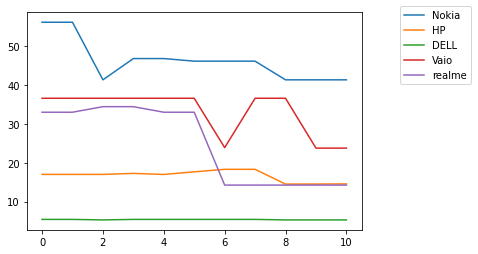

Time taken to complete Q11 in seconds:124.30600905418396


In [14]:
start = time.time()


############## Q11 ############
print ("Analysis of companies changing their discount rates over the time period based on competitors' rates for products with the same hardware and software specifications for Mobiles and Laptops.")
#laptop_spec_filter = {'GB SSD': '512', 'RAM' : '16 GB ', 'Processor': 'Intel Core i', 'Operating System': '64 bit Windows'}
laptop_spec_filter = {'GB SSD': '512', 'RAM' : '8 GB DDR4', 'Processor': '', 'Operating System': ''}
#mobile_spec_filter = {'GB ROM': '64', 'GB RAM' : '4', 'Processor': '', 'mAh': '5000'}
#df_product_comparision = topBrandOfferComparision ('mobiles', mobile_spec_filter)
df_product_comparision = topBrandOfferComparision ('laptops', laptop_spec_filter)

p = df_product_comparision.toPandas()

y=p['off_list'].values.tolist()
x=p['Brand'].values.tolist()

fig = plt.figure()
ax = plt.subplot(111)
index = 0
for i in x:
    ax.plot(y[index], label=x[index])
    index = index + 1

ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

end = time.time()
print("Time taken to complete Q11 in seconds:" + str(end - start))





Q12. Changes in discount rates based on increase in number of reviews/rating for each product over the given time period for various product and companies.


Changes in discount rates based on increase in number of reviews/rating for each product over the given time period for various product and companies. 
{'GB SSD': '512', 'RAM': '16 GB ', 'Processor': 'Intel Core i', 'Operating System': '64 bit Windows'}
+----------+----------+-----+
|Rating    |Offer     |count|
+----------+----------+-----+
|Decreasing|Decreasing|12   |
|Decreasing|Increasing|5    |
|Increasing|Increasing|8    |
|Increasing|Decreasing|20   |
+----------+----------+-----+

+--------+----------+----------+-----+
|Brand   |Rating    |Offer     |count|
+--------+----------+----------+-----+
|ASUS    |Decreasing|Increasing|2    |
|ASUS    |Increasing|Decreasing|4    |
|ASUS    |Increasing|Increasing|4    |
|ASUS    |Decreasing|Decreasing|2    |
|DELL    |Decreasing|Increasing|2    |
|DELL    |Increasing|Decreasing|1    |
|DELL    |Decreasing|Decreasing|3    |
|GIGABYTE|Increasing|Decreasing|1    |
|HP      |Increasing|Decreasing|7    |
|HP      |Increasing|Increasing|3    

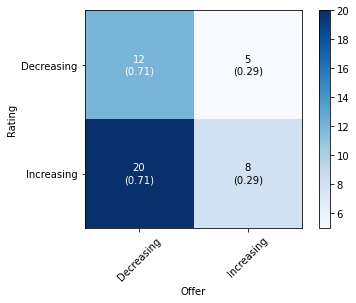

Time taken to complete Q12 184.15839624404907


In [15]:


start = time.time()
print ("Changes in discount rates based on increase in number of reviews/rating for each product over the given time period for various product and companies. ")
############## Q12 ############
laptop_spec_filter = {'GB SSD': '512', 'RAM' : '16 GB ', 'Processor': 'Intel Core i', 'Operating System': '64 bit Windows'}
#laptop_spec_filter = {'GB SSD': '', 'RAM' : '', 'Processor': '', 'Operating System': ''}
df_top_brand_reviews_vs_offer = topBrandReviewsVsOffer ('laptops', laptop_spec_filter)

df_top_brand_reviews_vs_offer_sorted = df_top_brand_reviews_vs_offer.sort('Rating','Offer')
p = df_top_brand_reviews_vs_offer_sorted.toPandas()

print (p)
 
target_names = ['Decreasing','Increasing']


cmat = np.array([[p['count'][0],p['count'][1]],
                 [p['count'][2],p['count'][3]]])
fig, ax = plot_confusion_matrix(conf_mat=cmat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True )

#plt.labels(class_names)
plt.ylabel('Rating')
plt.xlabel('Offer')
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
#class_names=class_dict)
plt.show()


end = time.time()
print("Time taken to complete Q12 " + str(end - start))

Q13.  Volatility of discount rates for stable products Vs. newly introduced products. Will use number of ratings/reviews as an indicator for new & old products.


###########################################################
Volatility of discount rates for stable products Vs. newly introduced products. Will use number of ratings/reviews as an indicator for new & old products. 
{'GB SSD': '', 'RAM': '', 'Processor': '', 'Operating System': ''}
+---------------------------------------------------------------------------------------------------------+-------------+-------------+------+----------+------+---------+------+--------------------+-----------------------+-----------------+-----------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------+----------+----------+---------------+------------------+----------+
|name                                                                                                     |total_ratings|total_reviews|rating|created_at|Brand |off      |GB SSD|RAM                 |Processor             

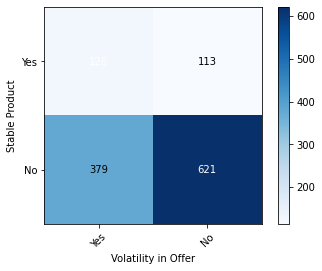

Time taken to complete Q13 in seconds : 236.7771453857422
Time taken to complete Q13 in seconds:236.7773561477661


In [16]:
start = time.time()
print ("###########################################################")
print ("Volatility of discount rates for stable products Vs. newly introduced products. Will use number of ratings/reviews as an indicator for new & old products. ")
############## Q13 ############
laptop_spec_filter = {'GB SSD': '512', 'RAM' : '16 GB ', 'Processor': 'Intel Core i', 'Operating System': '64 bit Windows'}
laptop_spec_filter = {'GB SSD': '', 'RAM' : '', 'Processor': '', 'Operating System': ''}
df_vol_of_new_and_old_prod = compareVolatilityOfNewAndOld ('laptops', laptop_spec_filter)


df_vol_of_new_and_old_prod_sorted = df_vol_of_new_and_old_prod.sort('IsStableProduct','Volatilile')
p = df_vol_of_new_and_old_prod_sorted.toPandas()
print(p)

target_names = ['Yes','No']


cmat = np.array([[p['count'][3],p['count'][2]],
                 [p['count'][1],p['count'][0]]])
fig, ax = plot_confusion_matrix(conf_mat=cmat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False)


#plt.labels(class_names)
plt.ylabel('Stable Product')
plt.xlabel('Volatility in Offer')
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
#class_names=class_dict)
plt.show()



end = time.time()
print("Time taken to complete Q13 in seconds : " + str(end - start))



end = time.time()
print("Time taken to complete Q13 in seconds:" + str(end - start))

Q14. Variations in discount rate of different models of the same product for a company over the given time period.

In [17]:
#Q14

def off_split(tex):
  if tex == 0:
    return(0)
  pos = tex.find('%')
  res = tex[0:pos]
  res1 = res.replace("%","")
  try:
    x = float(res1)
  except:
    x = 0
  return(x)

mob1 = spark.sql(" select name,offer_price,off_now from global_temp.all where category = 'mobiles'")
spark.catalog.dropGlobalTempView("mobiles")
mob1.createGlobalTempView("mobiles")
mordd = mob1.rdd.map(lambda x: (x["name"],x["offer_price"],na_split(x["name"]),off_split(x["off_now"])))
dfColumns = ["name","price","company","off"]
mob2 = mordd.toDF(dfColumns)
spark.catalog.dropGlobalTempView("mob2")
mob2.createGlobalTempView("mob2")
mob3 = spark.sql(" select company,max(off) max_off from global_temp.mob2 group by company")
spark.catalog.dropGlobalTempView("mob3")
mob3.createGlobalTempView("mob3")
mob4 = spark.sql(" select company,min(off) min_off from global_temp.mob2 where off > 0 group by company")
spark.catalog.dropGlobalTempView("mob4")
mob4.createGlobalTempView("mob4")
mob5 = spark.sql(" select mo.name,mo.company,price,off,'Maximum offer price is given' as desc from global_temp.mob2 mo inner join global_temp.mob3 max on mo.company=max.company and mo.off=max_off")
spark.catalog.dropGlobalTempView("mob5")
mob5.createGlobalTempView("mob5")
mob6 = spark.sql(" select mo.name,mo.company,price,off,'Minimum offer price is given' as desc from global_temp.mob2 mo inner join global_temp.mob4 min on mo.company=min.company and mo.off=min_off")
spark.catalog.dropGlobalTempView("mob6")
mob6.createGlobalTempView("mob6")
mob7 = spark.sql(" select name,company,price,off,desc from global_temp.mob5 union select name,company,price,off,desc from global_temp.mob6")
spark.catalog.dropGlobalTempView("mob7")
mob7.createGlobalTempView("mob7")
answer = spark.sql(" select name,company,price,off,desc from global_temp.mob7 order by company")

answer.show(n=100,truncate=False)

+-------------------------------------------------------------+----------+-------+----+----------------------------+
|name                                                         |company   |price  |off |desc                        |
+-------------------------------------------------------------+----------+-------+----+----------------------------+
|APPLE iPhone 13 Mini (Midnight, 256 GB)                      |APPLE     |68990.0|7.0 |Minimum offer price is given|
|APPLE iPhone 13 Mini (Blue, 256 GB)                          |APPLE     |68990.0|7.0 |Minimum offer price is given|
|APPLE iPhone 12 Mini (White, 64 GB)                          |APPLE     |37990.0|36.0|Maximum offer price is given|
|APPLE iPhone 12 Mini (Black, 64 GB)                          |APPLE     |37990.0|36.0|Maximum offer price is given|
|APPLE iPhone 13 Mini ((PRODUCT)RED, 256 GB)                  |APPLE     |68990.0|7.0 |Minimum offer price is given|
|APPLE iPhone 13 Mini (Pink, 256 GB)                          |A

Common init

In [18]:
#######################################
###!@2 START OF DEFINING INPUT FILES
tfile = "/content/drive/MyDrive/Data Engineering Project/Dataset/Consolidated_Data/Data_noimages_old"
tfile = "/content/drive/MyDrive/Data Engineering Project/Data/Data"
#tfile = "/content/drive/MyDrive/Data Engineering Project/Dataset/Consolidated_Data/Data_noimages_new"
#tfile = "/content/drive/MyDrive/Data Engineering Project/Dataset/Consolidated_Data/Data_noimages_both"
###!@2 END OF DEFINING INPUT FILES

from pyspark import SparkContext, SparkConf
import pyspark
import sys
import json
import numpy as np
from collections import defaultdict
import functools
from datetime import datetime

def sort_csvs(xname, yname):
  xday,xmonth,xyear = list(map(int, xname.split(".")[0].split("_")))
  yday,ymonth,yyear = list(map(int, yname.split(".")[0].split("_")))
  if xyear != yyear:
    return xyear - yyear
  elif xmonth != ymonth:
    return xmonth - ymonth
  else:
    return xday - yday

df = defaultdict(lambda: dict())
df_rdd = defaultdict(lambda:dict())

categories = "laptops mobiles other_electronics/ac other_electronics/fridge \
              other_electronics/smartwatch other_electronics/washingmachine \
              other_electronics/waterpurifier peripherals/earbuds peripherals/hdd \
              peripherals/memory_cards peripherals/monitor peripherals/pen_drives \
              peripherals/power_bank peripherals/ssd peripherals/wired_headset tablet tvs"

parameter_list = ["u_id", "name", "offer_price", "original_price", "off_now",
                 "total_ratings", "total_reviews", "rating", "description",
                 "item_link", "created_at"]

for category in categories.split():
  csv_list = os.listdir(tfile+"/"+category)
  if "images" in csv_list:
    csv_list.remove("images")
    
  #print(csv_list)
  for csv_file in sorted(csv_list, key=functools.cmp_to_key(sort_csvs)):
    print("Reading file path:", tfile+"/"+category+"/"+csv_file)

    df[category][csv_file] = spark.read.option("header",True).csv(tfile+"/"+category+"/"+csv_file)
    # If needed, can be used to do RDD-level compute later
    # df_rdd[category][csv_file] = df[category][csv_file].rdd
    # print("Shape:", (df_rdd[category][csv_file].count(), len(df_rdd[category][csv_file].take(1)[0])))

companies = defaultdict(lambda: set())


Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/23_09_2022.csv
Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/24_09_2022.csv
Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/25_09_2022.csv
Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/26_09_2022.csv
Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/27_09_2022.csv
Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/28_09_2022.csv
Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/29_09_2022.csv
Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/30_09_2022.csv
Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/01_10_2022.csv
Reading file path: /content/drive/MyDrive/Data Engineering Project/Data/Data/laptops/05_10_2022.csv


Q.4 (Mobile companies with max and min discount)

Mobiles:
Time: 0:00:02.503456 seconds


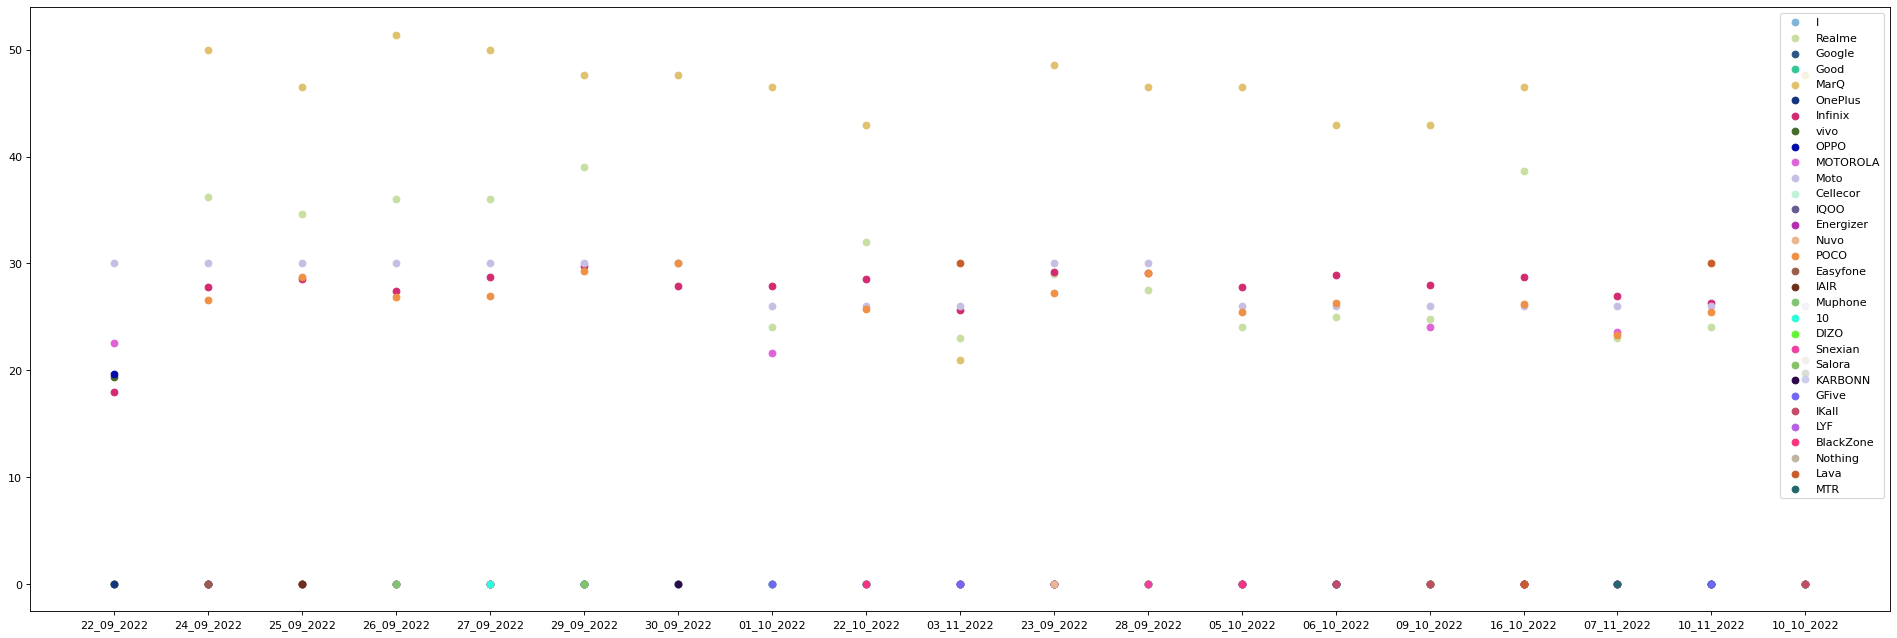

In [19]:
import matplotlib.pyplot as plt
import matplotlib
import random

print("Mobiles:")
category = "mobiles"
mobiles_discount = defaultdict(lambda: list())
csv_list = os.listdir(tfile+"/"+category)
csv_index = 0

start = datetime.now()
for csv_file in sorted(csv_list, key=functools.cmp_to_key(sort_csvs)):
  company_list = df[category][csv_file].select('name', 'off_now').collect()

  companies_disc = defaultdict(lambda: list())
  for c in company_list:
    companies[category].add(c[0].split()[0])

    if c[1] is None:
      companies_disc[c[0].split()[0]].append(0)
    else:
      companies_disc[c[0].split()[0]].append(int(c[1].split('%')[0]))

  disc_map = {}
  for company in companies_disc:
    disc_map[company] = np.average(np.array(companies_disc[company]))

  # print("Index", csv_index, sorted(disc_map.items(), key=lambda x: x[1]))
  mobiles_discount[csv_file] = sorted(disc_map.items(), key=lambda x: x[1])
  csv_index+=1

end = datetime.now()
print("Time:", end-start, "seconds")

graph_data = defaultdict(list)
for date in mobiles_discount.keys():
  tmp_dict = dict(mobiles_discount[date])
  i = 0
  for company in tmp_dict.keys():
    if i > 5 and i < (len(tmp_dict.keys()) - 5):
      i += 1
      continue
    graph_data[company].append((date, tmp_dict[company]))
    i += 1

plt.figure(figsize=(30, 10), dpi=80)
for company in graph_data.keys():
  date_list = [i[0].split(".")[0] for i in graph_data[company]]
  value_list = [i[1] for i in graph_data[company]]
  plt.scatter(date_list, value_list, color=(random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)))

plt.legend(graph_data.keys())
plt.show()

**Q**.5 Trends for discounts on mobile, laptop and tablets for same company

Laptops:
Tablets:
Common companies:  {'realme', 'Nokia', 'APPLE', 'ASUS', 'SAMSUNG'}
Time: 0:00:01.845102 seconds


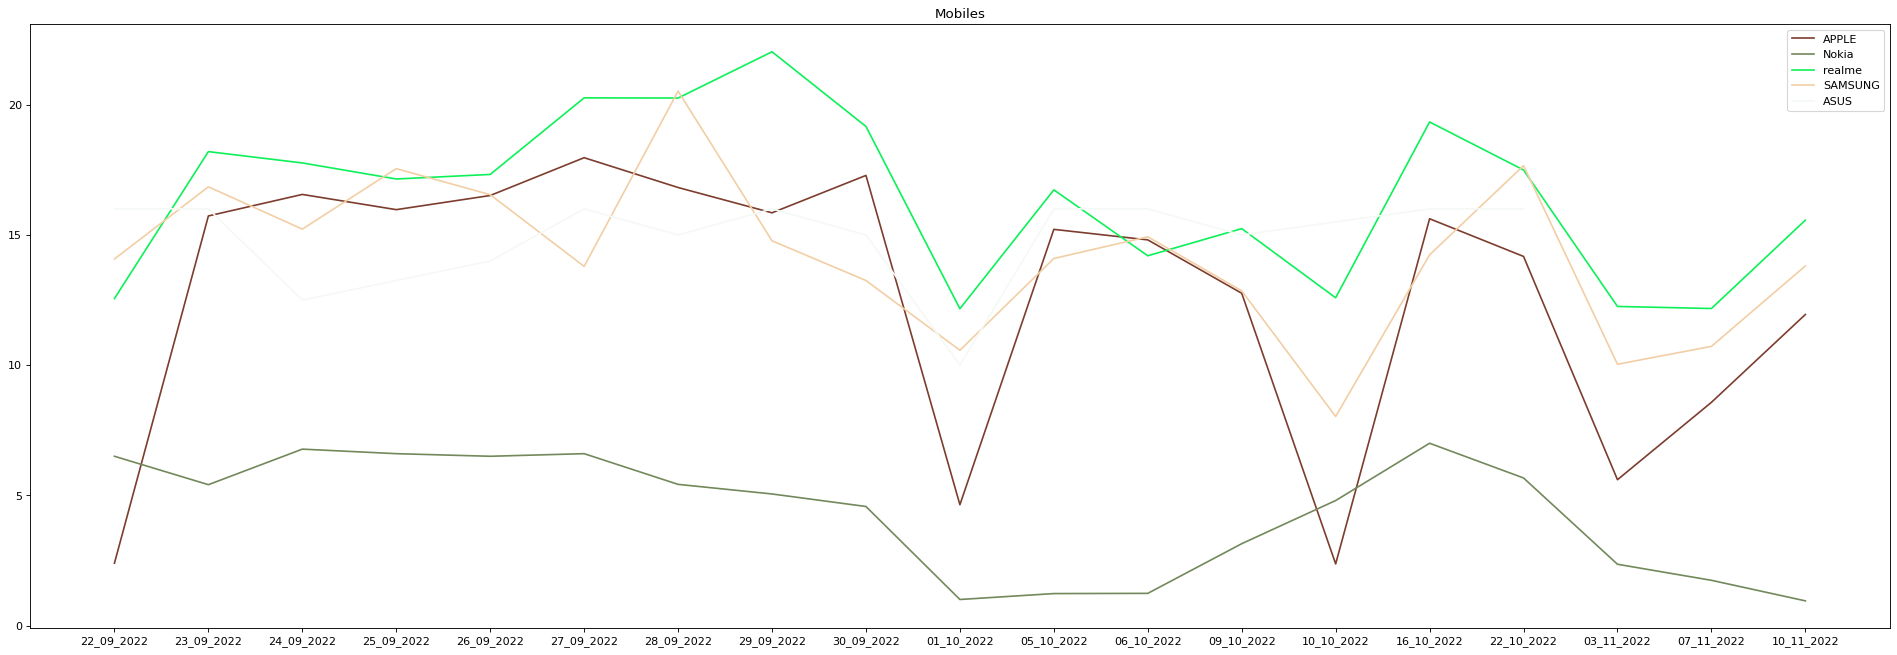

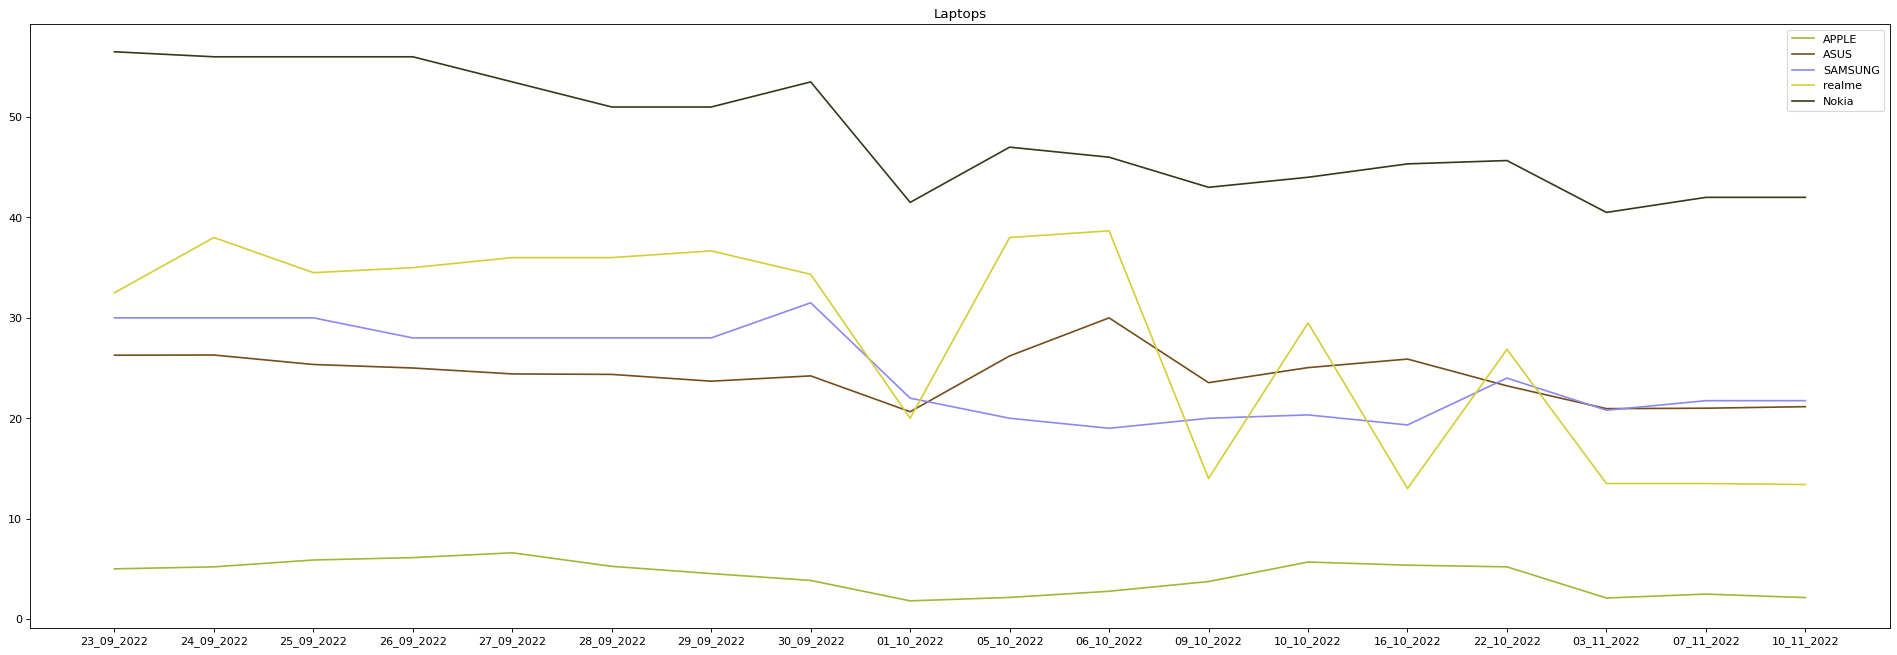

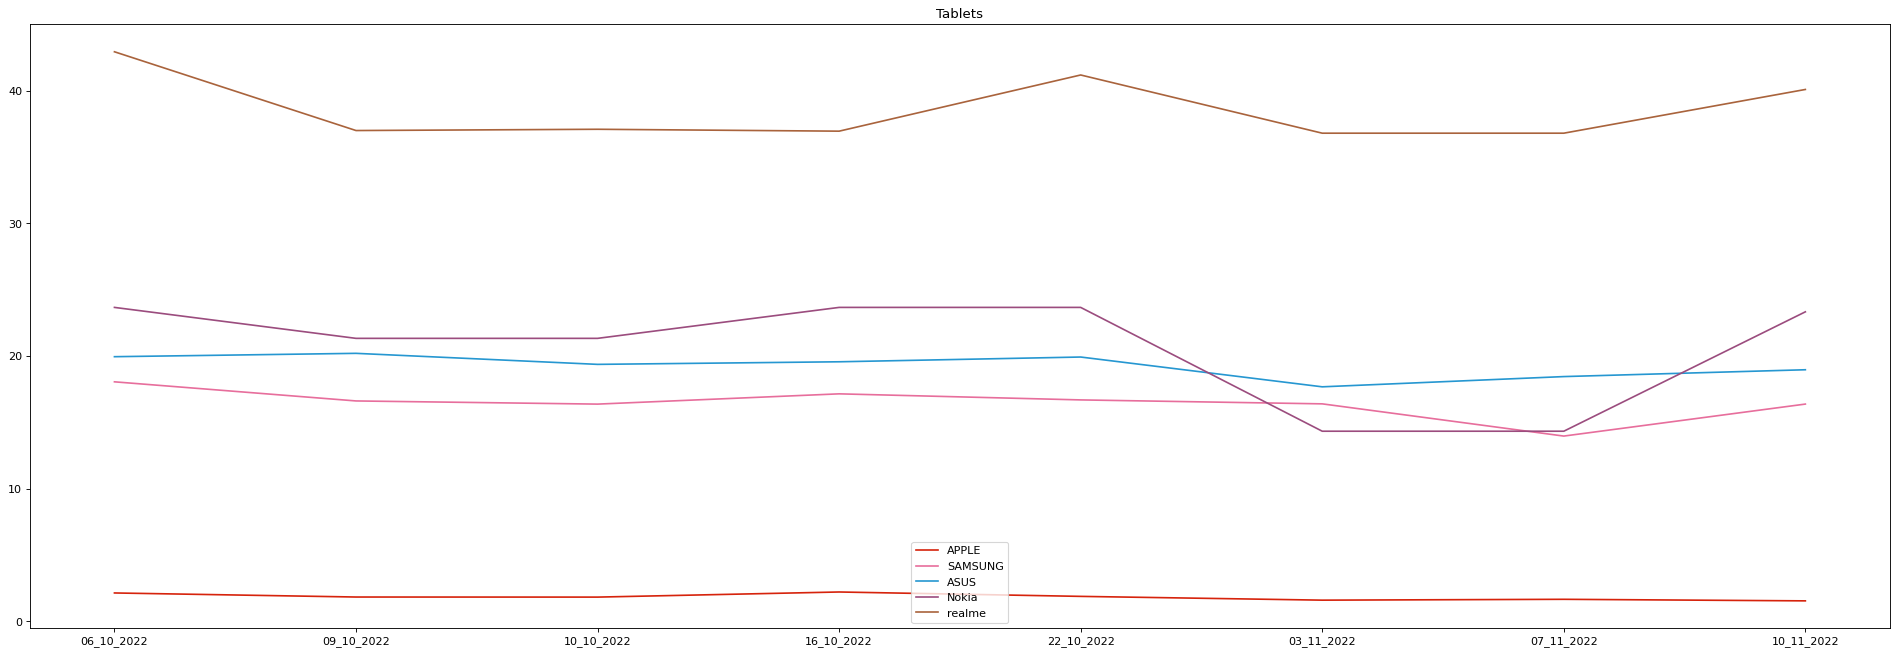

In [20]:
print("Laptops:")
category = "laptops"
laptops_discount = defaultdict(lambda: list())
csv_list = os.listdir(tfile+"/"+category)
csv_index = 0

start = datetime.now()
for csv_file in sorted(csv_list, key=functools.cmp_to_key(sort_csvs)):
  company_list = df[category][csv_file].select('name', 'off_now').collect()
  companies_disc = defaultdict(lambda: list())
  for c in company_list:
    companies[category].add(c[0].split()[0])

    if c[1] is None:
      companies_disc[c[0].split()[0]].append(0)
    else:
      companies_disc[c[0].split()[0]].append(int(c[1].split('%')[0]))

  disc_map = {}
  for company in companies_disc:
    disc_map[company] = np.average(np.array(companies_disc[company]))

  # print("Index", csv_index, sorted(disc_map.items(), key=lambda x: x[1]))
  laptops_discount[csv_file] = sorted(disc_map.items(), key=lambda x: x[1])
  csv_index+=1

#print(laptops_discount)

print("Tablets:")
category = "tablet"
tablet_discount = defaultdict(lambda: list())
csv_list = os.listdir(tfile+"/"+category)
csv_index = 0

for csv_file in sorted(csv_list, key=functools.cmp_to_key(sort_csvs)):
  company_list = df[category][csv_file].select('name', 'off_now').collect()

  companies_disc = defaultdict(lambda: list())
  for c in company_list:
    companies[category].add(c[0].split()[0])

    if c[1] is None:
      companies_disc[c[0].split()[0]].append(0)
    else:
      companies_disc[c[0].split()[0]].append(int(c[1].split('%')[0]))

  disc_map = {}
  for company in companies_disc:
    disc_map[company] = np.average(np.array(companies_disc[company]))

  # print("Index", csv_index, sorted(disc_map.items(), key=lambda x: x[1]))
  tablet_discount[csv_file] = sorted(disc_map.items(), key=lambda x: x[1])
  csv_index+=1

#print(tablet_discount)

#print("Mobiles", companies['mobiles'])
#print("Laptops", companies['laptops'])
#print("Tablets", companies['tablet'])

common_companies = companies['mobiles'].intersection(companies['laptops'].intersection(companies['tablet']))
print("Common companies: ", common_companies)

end = datetime.now()
print("Time:", end-start, "seconds")

# When printing graph, use the data in mobiles_discount, laptops_discount, tablet_discount
# and only select those entries where the company is in the above common set

# Mobiles
graph_data = defaultdict(list)
for date in mobiles_discount.keys():
  tmp_dict = dict(mobiles_discount[date])
  for company in tmp_dict.keys():
    graph_data[company].append((date, tmp_dict[company]))

common_list = []
plt.figure(figsize=(30, 10), dpi=80)
for company in graph_data.keys():
  if company not in common_companies:
    continue
  common_list.append(company)
  date_list = [i[0].split(".")[0] for i in graph_data[company]]
  value_list = [i[1] for i in graph_data[company]]
  plt.title("Mobiles")
  plt.plot(date_list, value_list, color=(random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)))

plt.legend(common_list)

# Laptops
graph_data = defaultdict(list)
for date in laptops_discount.keys():
  tmp_dict = dict(laptops_discount[date])
  for company in tmp_dict.keys():
    graph_data[company].append((date, tmp_dict[company]))

common_list = []
plt.figure(figsize=(30, 10), dpi=80)
for company in graph_data.keys():
  if company not in common_companies:
    continue
  common_list.append(company)
  date_list = [i[0].split(".")[0] for i in graph_data[company]]
  value_list = [i[1] for i in graph_data[company]]
  plt.title("Laptops")
  plt.plot(date_list, value_list, color=(random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)))

plt.legend(common_list)

# Tablets
graph_data = defaultdict(list)
for date in tablet_discount.keys():
  tmp_dict = dict(tablet_discount[date])
  for company in tmp_dict.keys():
    graph_data[company].append((date, tmp_dict[company]))

common_list = []
plt.figure(figsize=(30, 10), dpi=80)
for company in graph_data.keys():
  if company not in common_companies:
    continue
  common_list.append(company)
  date_list = [i[0].split(".")[0] for i in graph_data[company]]
  value_list = [i[1] for i in graph_data[company]]
  plt.title("Tablets")
  plt.plot(date_list, value_list, color=(random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)))

plt.legend(common_list)

plt.show()

Q.7 Top 2 companies with max discount percentage for HDD 1000 ratings and > 4 rating having similar specifications

In [21]:
print("HDD:")
category = "peripherals/hdd"
hdd_discount = defaultdict(lambda: list())
csv_list = os.listdir(tfile+"/"+category)
csv_index = 0

companies_disc = defaultdict(lambda: list())

print()
start = datetime.now()
for csv_file in sorted(csv_list, key=functools.cmp_to_key(sort_csvs)):
  company_list = df[category][csv_file].withColumn('total_ratings', df[category][csv_file]['total_ratings'].cast('int'))\
                                       .withColumn('rating', df[category][csv_file]['rating'].cast('float'))\
                                       .select('name', 'off_now', 'total_ratings', 'rating', 'description').collect()

  for c in company_list:
    try:
      # Customizable filter to exclude products with < 1000 ratings or < 4 stars
      if c[2] < 1000 or c[3] < 4:
        continue
      companies[category].add(c[0].split()[0])
      if c[1] is None:
        companies_disc[c[0]].append([0, ""])
      else:
        companies_disc[c[0]].append([int(c[1].split('%')[0]), c[4]])
    except:
      #print("Excepted with Row", c)
      continue

  csv_index+=1

spec_dic = defaultdict(lambda: list())
for entry in companies_disc.keys():
  for subentry in companies_disc[entry]:
    capacity = str([parameter for parameter in subentry[1].split(", ") if "Capacity" in parameter])
    if capacity == '[]':
      continue
    spec_dic[capacity].append((entry.split()[0], subentry[0]))

for spec in spec_dic.keys():
  print("Specification: ", spec)
  max_vendor1, max_vendor2 = "", ""
  max_discount1, max_discount2 = 0, 0
  for vendor,discount in spec_dic[spec]:
    if discount > max_discount1:
      if vendor == max_vendor1:
        max_discount1 = discount
      else:
        max_vendor2 = max_vendor1
        max_discount2 = max_discount1
        max_vendor1 = vendor
        max_discount1 = discount
    elif discount > max_discount2:
      if vendor == max_vendor2:
        max_discount2 = discount
      elif vendor != max_vendor1:
        max_discount2 = discount
        max_vendor2 = vendor

  if max_discount1 == 0:
    print("No discounts on this spec")
  else:
    print("Most discount for this spec: {}% from Vendor {}".format(max_discount1, max_vendor1))
    if max_discount2 != 0:
      print("Second most discount for this spec: {}% from Vendor {}".format(max_discount2, max_vendor2))
  print()

end = datetime.now()
print("Time:", end-start, "seconds")

HDD:

Specification:  ["'Capacity: 2 TB'"]
Most discount for this spec: 49% from Vendor TOSHIBA
Second most discount for this spec: 47% from Vendor WD

Specification:  ["'Capacity: 1.5 TB'"]
Most discount for this spec: 30% from Vendor WD

Specification:  ["'Capacity: 5 TB'"]
Most discount for this spec: 57% from Vendor WD
Second most discount for this spec: 33% from Vendor Seagate

Specification:  ["'Capacity: 1 TB'"]
Most discount for this spec: 53% from Vendor WD
Second most discount for this spec: 48% from Vendor TOSHIBA

Specification:  ["'Capacity: 4 TB'"]
Most discount for this spec: 55% from Vendor WD
Second most discount for this spec: 54% from Vendor Seagate

Specification:  ["'Capacity: 3 TB'"]
Most discount for this spec: 25% from Vendor WD

Time: 0:00:01.276863 seconds


Q.8 Which companies have mobile phones with consecutive increase in discount rates with less than a certain rating X.


In [22]:
category = "mobiles"
mobiles_discount = defaultdict(lambda: list())
csv_list = os.listdir(tfile+"/"+category)
csv_index = 0
companies_disc = defaultdict(lambda: list())

start = datetime.now()
for csv_file in sorted(csv_list, key=functools.cmp_to_key(sort_csvs)):
  # This is evaluated in the order of time
  company_list = df[category][csv_file].select('name', 'off_now', 'rating').collect()

  for c in company_list:
    if float(c[2]) > 3.5:
      continue
    companies[category].add(c[0].split()[0])

    if c[1] is None:
      companies_disc[c[0]].append(0)
    else:
      companies_disc[c[0]].append(int(c[1].split('%')[0]))
  csv_index+=1

increasing_companies = defaultdict(int)
for entry in companies_disc.keys():
  if (all(i < j for i, j in zip(companies_disc[entry], companies_disc[entry][1:]))):
    diff_discount = max(companies_disc[entry]) - companies_disc[entry][0]
    if not diff_discount:
      continue
    if increasing_companies[entry.split()[0]] < diff_discount:
      increasing_companies[entry.split()[0]] = diff_discount

if len(increasing_companies) == 0:
  print("No companies had a strict discount increase over the time period under rating threshold")
else:
  print("Companies which had a strict discount increase over the time period under rating threshold:")
  print()
  for company in increasing_companies:
    print("{}: {}% increase".format(company, increasing_companies[company]))

print()
increasing_companies = defaultdict(int)
for entry in companies_disc.keys():
  if (any(i < j for i, j in zip(companies_disc[entry], companies_disc[entry][1:]))):
    diff_discount = max(companies_disc[entry]) - companies_disc[entry][0]
    if not diff_discount:
      continue
    if increasing_companies[entry.split()[0]] < diff_discount:
      increasing_companies[entry.split()[0]] = diff_discount

if len(increasing_companies) == 0:
  print("No companies had a net discount increase at some point under rating threshold")
else:
  print("Companies which had a net discount increase at some point under rating threshold:")
  print()
  for company in increasing_companies:
    print("{}: {}% increase".format(company, increasing_companies[company]))

end = datetime.now()
print("Time:", end-start, "seconds")

Companies which had a strict discount increase over the time period under rating threshold:

vivo: 2% increase

Companies which had a net discount increase at some point under rating threshold:

vivo: 2% increase
realme: 1% increase
ANGAGE: 6% increase
Time: 0:00:01.434848 seconds


Q.9 Fluctuation of each company's aggregate discount rate over all the products during the sale.

Scanning products across common days for all categories: ['06_10_2022.csv', '10_11_2022.csv', '16_10_2022.csv', '10_10_2022.csv', '09_10_2022.csv']


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Time: 0:00:05.861417 seconds


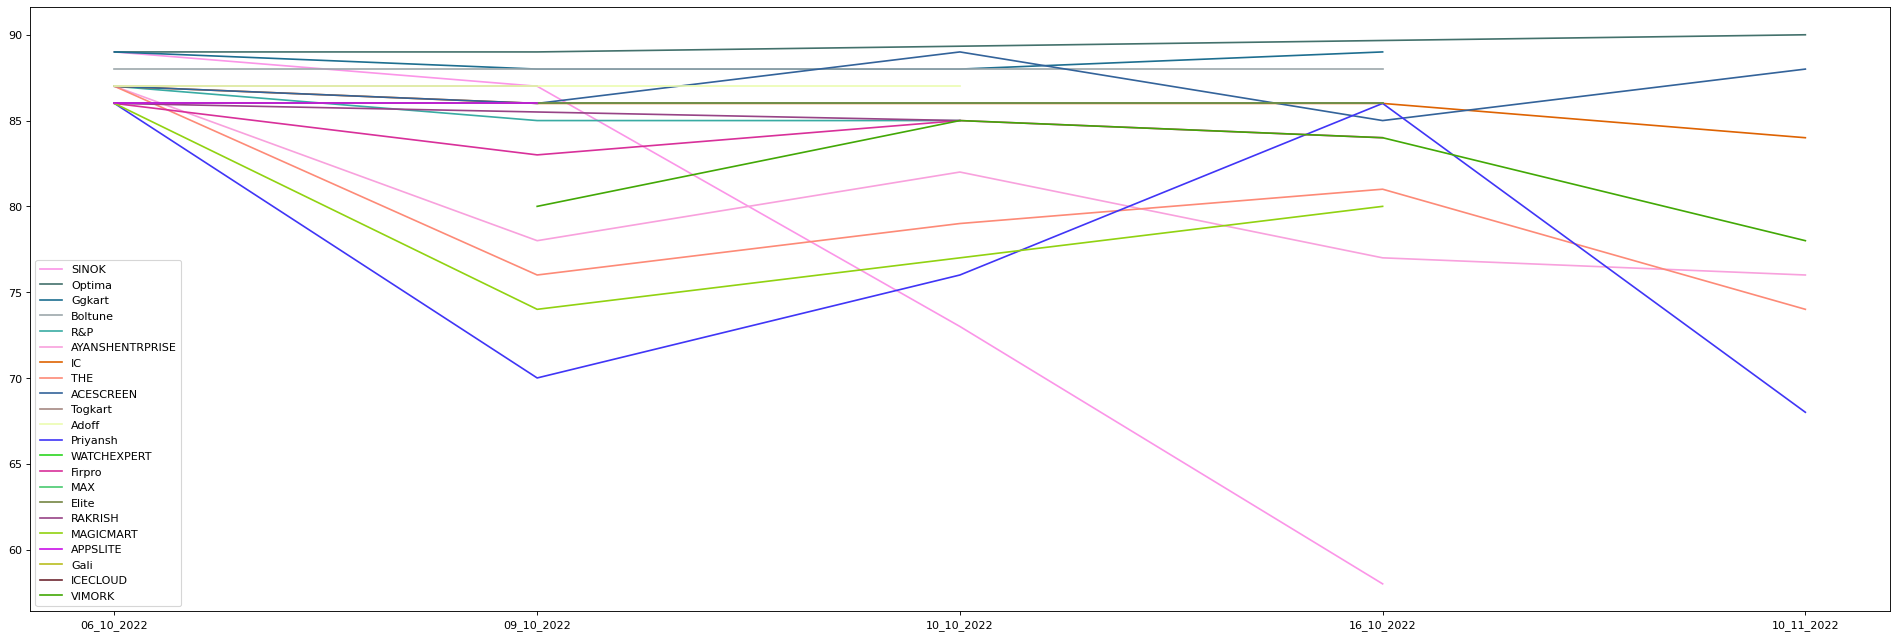

In [23]:
common_csvs = set()
common_init = 0
start = datetime.now()
for category in categories.split():
  csv_list = os.listdir(tfile+"/"+category)
  if not common_init:
    for csv in csv_list:
      common_csvs.add(csv)
      common_init = 1
  else:
    common_csvs = common_csvs.intersection(set(csv_list))

print("Scanning products across common days for all categories:", list(common_csvs))

companies_disc = defaultdict(lambda: defaultdict(lambda: list()))
companies_total = set()
for category in categories.split():
  csv_list = os.listdir(tfile+"/"+category)

  for csv_file in sorted(csv_list, key=functools.cmp_to_key(sort_csvs)):
    if csv_file.split("/")[-1] not in common_csvs:
      continue

    company_list = df[category][csv_file].select('name', 'off_now').collect()

    for c in company_list:
      try:
        companies_total.add(c[0].split()[0])

        if c[1] is None:
          companies_disc[csv_file][c[0].split()[0]].append(0)
        else:
          companies_disc[csv_file][c[0].split()[0]].append(int(c[1].split('%')[0]))
      except:
        #print("Encountered unexpected data format, skipping 1 row")
        pass

new_companies_disc = defaultdict(lambda: defaultdict(lambda: list()))
for csv_date in companies_disc.keys():
  new_companies_disc[csv_date] = dict()
  for company in companies_disc[csv_date].keys():
    agg = np.average(np.array(companies_disc[csv_date][company]))
    try:
      agg = int(agg)
      if (agg > 100) or (agg < 0):
        continue
    except:
      continue
    new_companies_disc[csv_date][company] = agg

for csv_date in new_companies_disc.keys():
  new_companies_disc[csv_date] = sorted(new_companies_disc[csv_date].items(), key=lambda x: x[1], reverse=True)

end = datetime.now()
print("Time:", end-start, "seconds")

graph_data = defaultdict(list)
date_count = 0
target_companies = set()

for date in new_companies_disc.keys():
  tmp_dict = dict(new_companies_disc[date])
  i = 0
  for company in tmp_dict.keys():
    if date_count == 0:
      target_companies.add(company)
      if i > 20:
        break
    elif company not in target_companies:
      continue
    graph_data[company].append((date, tmp_dict[company]))
    i += 1
  date_count += 1

plt.figure(figsize=(30, 10), dpi=80)
for company in graph_data.keys():
  date_list = [i[0].split(".")[0] for i in graph_data[company]]
  value_list = [i[1] for i in graph_data[company]]
  plt.plot(date_list, value_list, color=(random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)))

plt.legend(graph_data.keys())
plt.show()